set up

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Imports

from pipeline.data_read import *
from pipeline.image_prep import *
from pipeline.results_analysis import *

In [10]:
# Set constants

# Paths
dataset = "large"

if dataset == "small":
    audio_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/audio/small"
    image_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/images/small"
    csv_filepath = "C:/Users/anany/Cambridge/Part II Project/data/small.csv"
if dataset == "large":
    audio_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/audio/large"
    image_folderpath = "C:/Users/anany/Cambridge/Part II Project/data/images/large"
    csv_filepath = "C:/Users/anany/Cambridge/Part II Project/data/large.csv"

image_type = "spectrogram"

# Image options
clip_length = 1
shift_length = .5
resize_dim = 129
save = False

# Model parameters
generate = True
split_ratio = 0.8
k_folds = 5 # Only relevant if cross_validation is True
cross_validation = False
epochs = 6
gen_batch_size = 30 # Only relevant if generate is True
model_batch_size = 32

In [11]:
genre_id = get_genres(audio_folderpath)
genre_list = list(genre_id.keys())
label_list = [genre_id[genre] for genre in genre_list]

if save:
    audio_dict = get_audio_dict(audio_folderpath, genre_id) # TODO: CHANGE TO MAKE??
    all_song_ids = list(audio_dict.keys())
    convert_and_save(all_song_ids, audio_dict=audio_dict, image_type=image_type, image_folderpath=image_folderpath)
    create_csv(csv_filepath=csv_filepath, audio_dict=audio_dict)

else:
    audio_dict = get_audio_dict_csv(csv_filepath=csv_filepath)
    all_song_ids = list(audio_dict.keys())

train/test

In [12]:
if not cross_validation and not generate:
    train_song_ids, val_song_ids = split_train_test(id_list=all_song_ids, ratio=split_ratio)
    train_clip_ids, x_train, y_train = return_data(train_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, image_folderpath=image_folderpath)
    val_clip_ids, x_val, y_val = return_data(val_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, image_folderpath=image_folderpath)

    model = createModel(type=1, input_shape=x_train[0].shape)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=epochs, 
                        validation_data=(x_val, y_val))

    test_clip_confusion = np.zeros((len(label_list), len(label_list)))

    test_song_ids = val_song_ids
    test_clip_ids = val_clip_ids
    test_clip_pred_probs = model.predict(x_val)
    test_clip_pred_classes = test_clip_pred_probs.argmax(axis=1)
    test_clip_actual_classes = y_val.T[0]
    for i in range(len(test_clip_pred_classes)):
        test_clip_confusion[test_clip_pred_classes[i]][test_clip_actual_classes[i]] += 1
    
    norm_test_clip_confusion = np.zeros((len(label_list), len(label_list)))
    for i in range(len(label_list)):
        norm_test_clip_confusion[:, i] = test_clip_confusion[:, i]/sum(test_clip_confusion[:, i])

    test_clip_vote_array = np.zeros((len(test_clip_ids), len(label_list)))
    test_clip_vote_array += np.eye(5)[test_clip_pred_classes]
    #test_votes = (test_clip_ids, test_clip_vote_array)


In [13]:
if cross_validation and not generate:
    train_val_song_ids, test_song_ids = split_train_test(all_song_ids, split_ratio)
    batches = split_k_fold(train_val_song_ids, k_folds)

    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []

    val_clip_confusion = np.zeros((len(label_list), len(label_list)))
    norm_val_clip_confusion = np.zeros((len(label_list), len(label_list)))
    val_clip_vote_ids = []
    val_clip_vote_array = []


    test_clip_confusion = np.zeros((len(label_list), len(label_list)))
    norm_test_clip_confusion = np.zeros((len(label_list), len(label_list)))

    test_clip_ids, x_test, y_test = return_data(test_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, image_folderpath=image_folderpath)

    test_clip_vote_ids = test_clip_ids
    test_clip_vote_array = np.zeros((len(test_clip_ids), len(label_list)))
    

    for b in range(len(batches)):

        # Get data
        if b != len(batches) - 1:
            train_song_ids = batches[0:b] + batches[b+1:]
        else:
            train_song_ids = batches[:-1]
        
        train_song_ids = [item for batch in train_song_ids for item in batch]
        val_song_ids = batches[b]

        train_clip_ids, x_train, y_train = return_data(train_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, image_folderpath=image_folderpath)
        val_clip_ids, x_val, y_val = return_data(val_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, image_folderpath=image_folderpath)


        # Create model
        model = createModel(type=1, input_shape=x_train[0].shape)

        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
        
        # Train model
        history = model.fit(x_train, y_train, epochs=epochs, 
                            validation_data=(x_val, y_val))
        
        # Get results
        loss.append(np.array(history.history['loss']))
        accuracy.append(np.array(history.history['accuracy']))
        val_loss.append(np.array(history.history['val_loss']))
        val_accuracy.append(np.array(history.history['val_accuracy']))

        # Validation classification results
        val_clip_pred_probs = model.predict(x_val)
        val_clip_pred_classes = val_clip_pred_probs.argmax(axis=1)
        val_actual = y_val.T[0]
        for i in range(len(val_clip_pred_classes)):
            val_clip_confusion[val_clip_pred_classes[i]][val_actual[i]] += 1
        val_clip_vote_ids.append(val_clip_ids)
        val_clip_vote_array.append(np.eye(len(label_list))[val_clip_pred_classes])
        

        # Test classification results
        test_clip_pred_probs = model.predict(x_test)
        test_clip_pred_classes = test_clip_pred_probs.argmax(axis=1)
        test_clip_actual_classes = y_test.T[0]
        for i in range(len(test_clip_pred_classes)):
            test_clip_confusion[test_clip_pred_classes[i]][test_clip_actual_classes[i]] += 1
        test_clip_vote_array += np.eye(len(label_list))[test_clip_pred_classes]

    loss = np.array(loss)
    accuracy = np.array(accuracy)
    val_loss = np.array(val_loss)
    val_accuracy = np.array(val_accuracy)

    val_clip_vote_ids = np.concatenate(val_clip_vote_ids, axis=0)
    val_clip_vote_array = np.vstack(val_clip_vote_array)

    for i in range(len(label_list)):
        norm_val_clip_confusion[:, i] = val_clip_confusion[:, i]/sum(val_clip_confusion[:, i])
        norm_test_clip_confusion[:, i] = test_clip_confusion[:, i]/sum(test_clip_confusion[:, i])

In [14]:
if not cross_validation and generate:       # setup train/test, 

    train_song_ids, val_song_ids = split_train_test(id_list=all_song_ids, ratio=split_ratio)

    train_clip_set_len = len(get_clip_ids(train_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length))
    val_clip_set_len = len(get_clip_ids(val_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length))


    train_func = generate_data(train_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="train", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
    val_func = generate_data(val_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="train", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
    
    input_shape = (resize_dim, resize_dim, 1)

    model = createModel(input_shape=input_shape)
    # TODO: what if not resized -- how to get dimensions of an 

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0025),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    history = model.fit(train_func,
                        steps_per_epoch=int(train_clip_set_len/model_batch_size),
                                epochs=epochs,
                                validation_data=val_func,
                                validation_steps=int(val_clip_set_len/model_batch_size),
                                shuffle=True,
                                batch_size=model_batch_size)
    
    test_func = generate_data(val_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="test", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
    test_clip_pred_probs = model.predict(test_func)
    test_clip_pred_classes = test_clip_pred_probs.argmax(axis=1)

    test_clip_ids = get_clip_ids(val_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length) # this is correct, val_song_ids is test_song_ids
    test_clip_actual_classes = get_labels(test_clip_ids, label_list=label_list)

    test_clip_confusion = np.zeros((len(label_list), len(label_list)))
    for i in range(len(test_clip_pred_classes)):
        test_clip_confusion[test_clip_pred_classes[i]][test_clip_actual_classes[i]] += 1
    
    norm_test_clip_confusion = np.zeros((len(label_list), len(label_list)))
    for i in range(len(label_list)):
        norm_test_clip_confusion[:, i] = test_clip_confusion[:, i]/sum(test_clip_confusion[:, i])

    test_clip_vote_array = np.zeros((len(test_clip_ids), len(label_list)))
    test_clip_vote_array += np.eye(5)[test_clip_pred_classes]

    test_song_ids = val_song_ids
    #test_votes = (test_clip_ids, test_vote_array)

Epoch 1/6
  236/12627 [..............................] - ETA: 40:17 - loss: 1.3673 - accuracy: 0.0030

KeyboardInterrupt: 

In [ ]:
if cross_validation and generate:       # setup train/test, 

    train_val_song_ids, test_song_ids = split_train_test(all_song_ids, split_ratio)
    batches = split_k_fold(train_val_song_ids, k_folds)

    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []
    val_clip_confusion = np.zeros((len(label_list), len(label_list)))
    norm_val_clip_confusion = np.zeros((len(label_list), len(label_list)))

    val_clip_vote_ids = []
    val_clip_vote_array = []



    test_clip_confusion = np.zeros((len(label_list), len(label_list)))
    norm_test_clip_confusion = np.zeros((len(label_list), len(label_list)))
    #test_ids, x_test, y_test = return_data(test_id_list, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list, image_folderpath=image_folderpath)
    test_clip_ids = get_clip_ids(test_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length)
    test_clip_actual_classes = get_labels(test_clip_ids, label_list=label_list)

    test_clip_vote_ids = test_clip_ids
    test_clip_vote_array = np.zeros((len(test_clip_ids), len(label_list)))
 
    
    for b in range(len(batches)):

        # Get data
        if b != len(batches) - 1:
            train_song_ids = batches[0:b] + batches[b+1:]
        else:
            train_song_ids = batches[:-1]
        
        train_song_ids = [item for batch in train_song_ids for item in batch]
        val_song_ids = batches[b]

        train_func = generate_data(train_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="train", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
        val_func = generate_data(val_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="train", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)

        train_clip_ids = get_clip_ids(train_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length)
        val_clip_ids = get_clip_ids(val_song_ids, audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length)
        
        train_clip_set_len = len(train_clip_ids)
        val_clip_set_len = len(val_clip_ids)


        input_shape = (resize_dim, resize_dim, 1)

        model = createModel(input_shape=input_shape)

        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

        history = model.fit(train_func,
                            steps_per_epoch=int(train_clip_set_len/model_batch_size),
                                    epochs=epochs,
                                    validation_data=val_func,
                                    validation_steps=int(val_clip_set_len/model_batch_size),
                                    shuffle=True,
                                    batch_size=model_batch_size)
     
        # Get results
        loss.append(np.array(history.history['loss']))
        accuracy.append(np.array(history.history['accuracy']))
        val_loss.append(np.array(history.history['val_loss']))
        val_accuracy.append(np.array(history.history['val_accuracy']))

        # Validation classification results
        val_pred_func = generate_data(val_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="test", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
        val_clip_pred_probs = model.predict(val_pred_func)
        val_clip_pred_classes = val_clip_pred_probs.argmax(axis=1)

        val_clip_actual_classes = get_labels(val_clip_ids, label_list=label_list)
        for i in range(len(val_clip_pred_classes)):
            val_clip_confusion[val_clip_pred_classes[i]][val_clip_actual_classes[i]] += 1
        
        val_clip_vote_ids.append(val_clip_ids)
        val_clip_vote_array.append(np.eye(len(label_list))[val_clip_pred_classes])

        # Test classification results
        test_clip_pred_func = generate_data(test_song_ids, image_folderpath=image_folderpath, gen_batch_size=gen_batch_size, model_batch_size=model_batch_size, mode="test", audio_dict=audio_dict, clip_length=clip_length, shift_length=shift_length, resize_dim=resize_dim, label_list=label_list)
        test_clip_pred_probs = model.predict(test_clip_pred_func)
        test_clip_pred_classes = test_clip_pred_probs.argmax(axis=1)
        
        for i in range(len(test_clip_pred_classes)):
            test_clip_confusion[test_clip_pred_classes[i]][test_clip_actual_classes[i]] += 1
        test_clip_vote_array += np.eye(len(label_list))[test_clip_pred_classes]

    loss = np.array(loss)
    accuracy = np.array(accuracy)
    val_loss = np.array(val_loss)
    val_accuracy = np.array(val_accuracy)

    val_clip_vote_ids = np.concatenate(val_clip_vote_ids, axis=0)
    val_clip_vote_array = np.vstack(val_clip_vote_array)

    for i in range(len(label_list)):
        norm_val_clip_confusion[:, i] = val_clip_confusion[:, i]/sum(val_clip_confusion[:, i])
        norm_test_clip_confusion[:, i] = test_clip_confusion[:, i]/sum(test_clip_confusion[:, i])


analysis

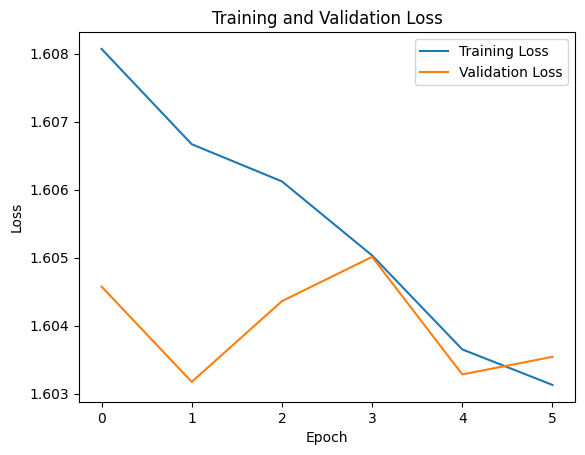

In [ ]:
# Loss Function

if not cross_validation:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


if cross_validation:
    plt.plot(sum(loss)/len(loss), label='Average Training Loss')
    plt.plot(sum(val_loss)/len(loss), label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

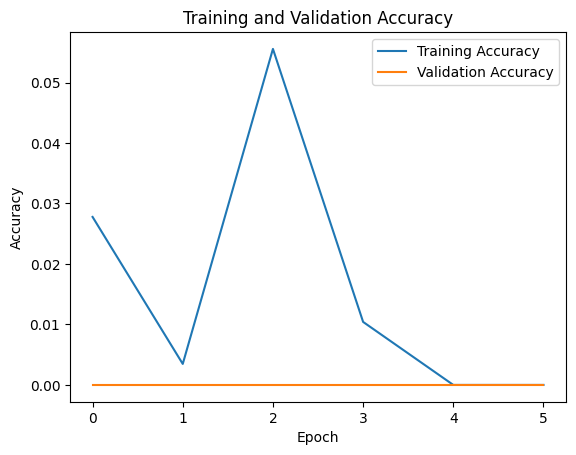

In [ ]:
# Accuracy Function

if not cross_validation:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if cross_validation:
    plt.plot(sum(accuracy)/len(accuracy), label='Average Training Accuracy')
    plt.plot(sum(val_accuracy)/len(val_accuracy), label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# Validation Clip Confusion Matrix

if cross_validation:

    fig, ax = plt.subplots()
    ax.imshow(norm_val_clip_confusion, cmap = "gray_r")

    labels = [item.get_text() for item in ax.get_yticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = genre_list[i - 1]

    ax.set_xticklabels(labels, rotation = 45, ha = "right")
    ax.set_yticklabels(labels)

    ax.set_xlabel("Actual class")
    ax.set_ylabel("Predicted class")
    ax.set_title("Validation Clip Confusion Matrix")

    plt.show()

C:\Users\anany\AppData\Local\Temp\ipykernel_16012\4017982822.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 45, ha = "right")
C:\Users\anany\AppData\Local\Temp\ipykernel_16012\4017982822.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


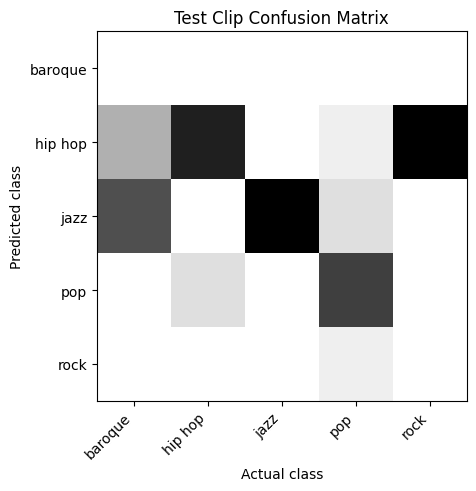

In [ ]:
# Test Clip Confusion Matrix

fig, ax = plt.subplots()
ax.imshow(norm_test_clip_confusion, cmap = "gray_r")

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(1, len(labels) - 1):
    labels[i] = genre_list[i - 1]

ax.set_xticklabels(labels, rotation = 45, ha = "right")
ax.set_yticklabels(labels)

ax.set_xlabel("Actual class")
ax.set_ylabel("Predicted class")
ax.set_title("Test Clip Confusion Matrix")

plt.show()

In [ ]:
c = classified_as(test_clip_ids, test_clip_pred_classes, test_clip_actual_classes, 0, 0)

if (len(c) != 0):
    example = random.randint(0, len(c) - 1)
    print(c[example])
    print(audio_dict[c[example][:4]])
    display(play(c[example]))
else:
    print("No such clips.")

No such clips.


In [ ]:
if cross_validation:
    val_song_vote_array = get_song_votes(val_song_ids, val_clip_ids, val_clip_vote_array)
    val_song_pred_classes = val_song_vote_array.argmax(axis=1)
    val_song_actual_classes = get_labels(val_song_ids, label_list)
    val_song_confusion = np.zeros((len(label_list), len(label_list)))

    for i in range(len(val_song_pred_classes)):
        val_song_confusion[val_song_pred_classes[i]][val_song_actual_classes[i]] += 1
    
    norm_val_song_confusion = np.zeros((len(label_list), len(label_list)))

    for i in range(len(label_list)):
        norm_val_song_confusion[:, i] = val_song_confusion[:, i]/sum(val_song_confusion[:, i])


test_song_vote_array = get_song_votes(test_song_ids, test_clip_ids, test_clip_vote_array)
test_song_pred_classes = test_song_vote_array.argmax(axis=1)
test_song_actual_classes = get_labels(test_song_ids, label_list)
test_song_confusion = np.zeros((len(label_list), len(label_list)))

for i in range(len(test_song_pred_classes)):
    test_song_confusion[test_song_pred_classes[i]][test_song_actual_classes[i]] += 1

norm_test_song_confusion = np.zeros((len(label_list), len(label_list)))

for i in range(len(label_list)):
    norm_test_song_confusion[:, i] = test_song_confusion[:, i]/sum(test_song_confusion[:, i])


In [ ]:
# Validation Song Confusion Matrix

if cross_validation:
    fig, ax = plt.subplots()
    ax.imshow(norm_val_song_confusion, cmap = "gray_r")

    labels = [item.get_text() for item in ax.get_yticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = genre_list[i - 1]

    ax.set_xticklabels(labels, rotation = 45, ha = "right")
    ax.set_yticklabels(labels)

    ax.set_xlabel("Actual class")
    ax.set_ylabel("Predicted class")
    ax.set_title("Validation Song Confusion Matrix")

    plt.show()

C:\Users\anany\AppData\Local\Temp\ipykernel_16012\3690557277.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 45, ha = "right")
C:\Users\anany\AppData\Local\Temp\ipykernel_16012\3690557277.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


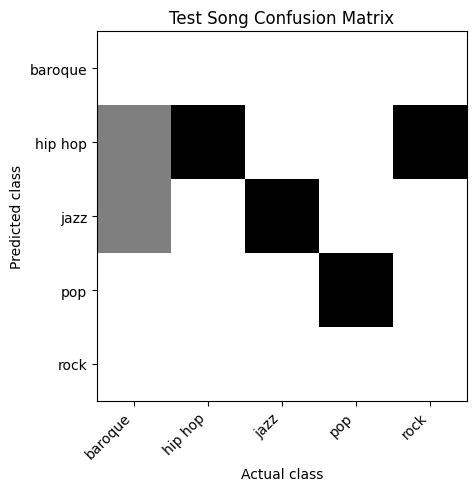

In [ ]:
# Test Song Confusion Matrix

fig, ax = plt.subplots()
ax.imshow(norm_test_song_confusion, cmap = "gray_r")

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(1, len(labels) - 1):
    labels[i] = genre_list[i - 1]

ax.set_xticklabels(labels, rotation = 45, ha = "right")
ax.set_yticklabels(labels)

ax.set_xlabel("Actual class")
ax.set_ylabel("Predicted class")
ax.set_title("Test Song Confusion Matrix")

plt.show()